In [13]:

from matplotlib import pyplot as plt
import numpy as np

from astropy.coordinates import solar_system_ephemeris
from astropy.time import Time, TimeDelta
from astropy import units as u

from poliastro.bodies import Earth, Moon
from poliastro.constants import rho0_earth, H0_earth

from poliastro.core.elements import rv2coe
from poliastro.core.perturbations import (J2_perturbation, atmospheric_drag_exponential, third_body)
from poliastro.core.propagation import func_twobody 
from poliastro.ephem import build_ephem_interpolant
from poliastro.plotting import OrbitPlotter2D, OrbitPlotter3D
from poliastro.twobody import Orbit
from poliastro.twobody.propagation import CowellPropagator
from poliastro.twobody.sampling import EpochsArray
from poliastro.util import norm, time_range, Time

In [15]:
R = Earth.R.to(u.km).value
k = Earth.k.to(u.km**3 / u.s**2).value
a    = 6800 * u.kilometer
ecc  = .0016628 * u.one
inc  = 97.4864 * u.deg
raan = 39.164 * u.deg
argp = 325.3203 * u.deg
nu   = 126.202 * u.deg


In [16]:
C_D = 2.2
A_over_m = ((np.pi/4.0) * (u.m**2) / (100 * u.kg)).to_value(u.km**2 / u.kg) # km**2/kg
B = C_D * A_over_m   # ballistic coefficient

In [18]:
rho0 = rho0_earth.to(u.kg/u.km**3).value
H0   = H0_earth.to(u.km).value

In [19]:
from numba import njit as jit
@jit
def a_d(t0, state, k, J2, R, C_D, A_over_m, H0, rho0):
    return J2_perturbation(t0, state, k, J2, R) + atmospheric_drag_exponential(
        t0, state, k, R, C_D, A_over_m, H0, rho0
    )

def f(t0, state, k):
    du_kep = func_twobody(t0, state, k)
    ax, ay, az = a_d(t0, state, k, R=R, C_D=C_D, A_over_m=A_over_m, H0=H0, rho0=rho0, j2=Earth.J2.value)
    du_ad = np.array([0, 0, 0, ax, ay, az])

    return du_kep + du_ad

In [22]:
epoch = Time("2018-11-30 03:53:03.550", scale="utc")
rhw0 = Orbit.from_classical(Earth, a, ecc, inc, raan, argp, nu, epoch)
tofs = TimeDelta(np.linspace(0, 10 * u.day, num=10 * 500))

def f(t0, state, k):
    du_kep = func_twobody(t0, state, k)
    ax, ay, az = a_d(
        t0,
        state,
        k,
        R=R,
        C_D=C_D,
        A_over_m=A_over_m,
        H0=H0,
        rho0=rho0,
        J2=Earth.J2.value,
    )
    du_ad = np.array([0, 0, 0, ax, ay, az])

    return du_kep + du_ad

rr3, _ = rhw0.to_ephem(EpochsArray(rhw0.epoch + tofs, method=CowellPropagator(f=f)),).rv()

AttributeError: module 'matplotlib.pyplot' has no attribute 'figsize'

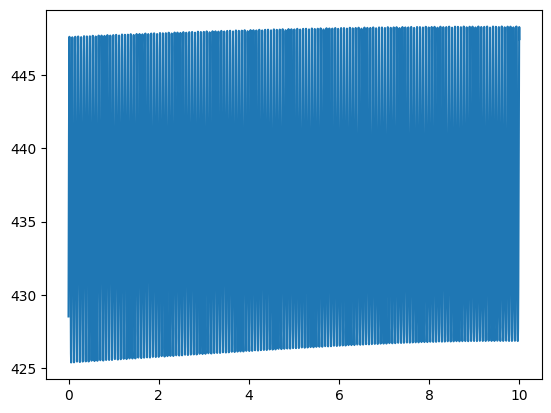

In [42]:
plt.plot(tofs.value, norm(rr3, axis=1) - Earth.R)
plt.figsize([15,16])
plt.ylabel("h(t)")
plt.xlabel("t, days")
plt.ylim([400, 450])